# Danhui's project (Spring 2019)

This project is done partly to support the competitor & market research for REDOX. REDOX is a lab services company that uses novel imaging techniques to provide scientists in pharmaceutical companies with unprecedented subcellular-level metabolic information to help understand drug-cellular interactions and thereby aiding the drug discovery and development process and reducing wasted resources. Through analyzing three optical biomarkers - cellular redox state, bound NADH fraction, and mitochondrial clustering - we are able to provide information on the metabolic activity happening within the cells. Currently we are capable of providing insights into specific metabolic pathways, including glycolysis, glutaminolysis, mitochondrial uncoupling, fatty acid oxidation, and fatty acid synthesis, with single-cell resolution.

Though our previous understanding was that the pharmaceutical industry currently only measures the level of metabolites in cells or bulk metrics and does not measure cell-differentiated metabolic activity, our recent research and interviews reveal that some companies are looking into specific metabolic pathways which overlap with our service offerings. As the field of measuring metabolic activity in drug research is still in its nascent stage, specific disease models that work well with our product are not yet validated. Therefore, through looking into applications of our competitor’s products (published in scientific journals), our team may find drug research of specific disease types/cell lines that may serve our beachhead market. The dataset used in this project is found on Agilent Cell Reference Database:
https://www.agilent.com/cell-reference-database/

### Why is looking into cellular metabolism-related research important?
* Use case 1: The MYC oncogene is frequently mutated and overexpressed in human renal cell carcinoma (RCC). Research shows that MYC-induced RCC up-regulated the glutaminolytic pathway instead of the glycolytic pathway. The pharmacologic inhibition of glutamine metabolism with bis-2-(5-phenylacetamido-1,2,4-thiadiazol-2-yl) ethyl sulfide impeded MYC-mediated tumor progression. Thus, the inhibition of glutamine metabolism is a potential therapeutic approach for the treatment of this disease. (Shroff et al. PNAS 2015)
* Use case 2: Insights into tumor cellular metabolism upon administration of therapeutics can serve as an early predictor of *in vivo* tumor drug response. In the current standard of care, patients with innate drug resistance are not identified *a priori* and drug effectiveness is determined after weeks of treatment from tumor size measurements using mammography, MRI, or ultrasound. Research showed that observations of cellular metabolic changes can predict tumor drug response much earlier than the traditional imaging methods, at about 72 hours after administration. (Walsh et al. 2014)

Learning about more use cases like the aforementioned research areas can help REDOX better navigate the current research landscape and gain an in-depth understanding of current methods used to measure cellular metabolism. With this knowledge, REDOX can hope to best position itself in the market with its differentiating features.



In [825]:
import pandas as pd
import numpy as np
import re

# Generate Word Cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [826]:
data = pd.read_csv('./CellLineInput.csv')
data.head()

,Title,Authors,Journal,Publication date,Research area,Cell Line,Cell Type,Species,Analyzer,XF Assay,Plate Reader Assay,Seeding density,Plate coating
0,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Oct 1 2014 12:00 AM,Immunology Research,T-cells,T-cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified
1,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Oct 1 2014 12:00 AM,Immunology Research,Natural Killer (NK) cells,Immune Cells,Mouse,24,Cell Mitochondrial Stress Test,NaN,8.0x10^5 cells/well,Not Specified
2,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Sep 21 2018 12:00 AM,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Cell Mitochondrial Stress Test,NaN,3.0 x10^4 cells/well,Not Specified
3,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Sep 21 2018 12:00 AM,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Glycolysis Stress Test,NaN,3.0 x10^4 cells/well,Not Specified
4,_-ketoglutarate orchestrates macrophage activa...,"P. S. Liu, H. Wang, X. Li, T. Chao, T. Teav, S...",Nat Immunol,Sep 1 2017 12:00 AM,Immunology Research,Bone Marrow-Derived Macrophages (BMDM),Immune Cells,Mouse,96,Cell Mitochondrial Stress Test,NaN,1.0 x10^5 cells/well,Not Specified


In [827]:
rows = len(data.index)
print ('Number of rows in the table: ', rows)

Number of rows in the table:  9634


Text(0, 0.5, 'Percent Missing')

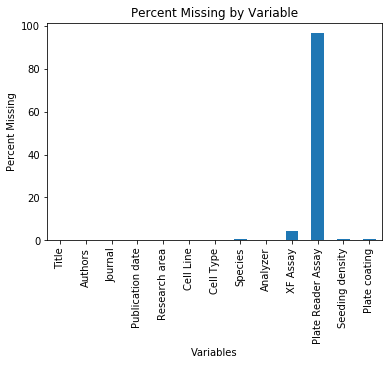

In [828]:
((data.isnull().sum()/len(data)) * 100).plot(kind='bar')
# Add title, x- and y- axes labels
plt.title('Percent Missing by Variable')
plt.xlabel("Variables")
plt.ylabel("Percent Missing")

Drop column that has mostly null values, then drop rows that have null values.

In [829]:
data = data.drop(columns='Plate Reader Assay')
data = data.drop(columns='Plate coating')
data.head()

,Title,Authors,Journal,Publication date,Research area,Cell Line,Cell Type,Species,Analyzer,XF Assay,Seeding density
0,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Oct 1 2014 12:00 AM,Immunology Research,T-cells,T-cells,Mouse,24,Cell Mitochondrial Stress Test,8.0x10^5 cells/well
1,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Oct 1 2014 12:00 AM,Immunology Research,Natural Killer (NK) cells,Immune Cells,Mouse,24,Cell Mitochondrial Stress Test,8.0x10^5 cells/well
2,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Sep 21 2018 12:00 AM,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Cell Mitochondrial Stress Test,3.0 x10^4 cells/well
3,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Sep 21 2018 12:00 AM,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Glycolysis Stress Test,3.0 x10^4 cells/well
4,_-ketoglutarate orchestrates macrophage activa...,"P. S. Liu, H. Wang, X. Li, T. Chao, T. Teav, S...",Nat Immunol,Sep 1 2017 12:00 AM,Immunology Research,Bone Marrow-Derived Macrophages (BMDM),Immune Cells,Mouse,96,Cell Mitochondrial Stress Test,1.0 x10^5 cells/well


In [830]:
# dropping null value columns to avoid errors 
data.dropna(inplace = True) 
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 11 columns):
Title               9083 non-null object
Authors             9083 non-null object
Journal             9083 non-null object
Publication date    9083 non-null object
Research area       9083 non-null object
Cell Line           9083 non-null object
Cell Type           9083 non-null object
Species             9083 non-null object
Analyzer            9083 non-null object
XF Assay            9083 non-null object
Seeding density     9083 non-null object
dtypes: object(11)
memory usage: 780.6+ KB


## Merge Datasets (Work in Progress)

New dataset is published for April 2019 and can be merged into the existing dataset.

## Data Cleaning & Visualization

### 1. Research area

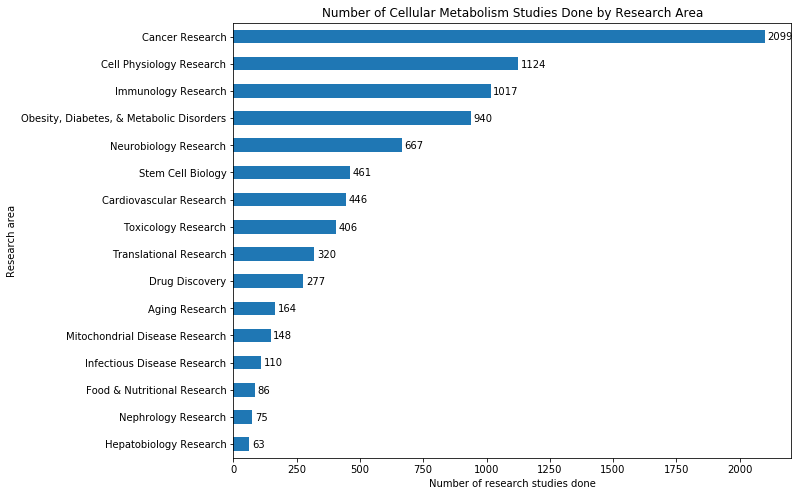

In [831]:
# Remove research areas that have a low value count
# Reference: https://stackoverflow.com/questions/32511061/remove-low-frequency-values-from-pandas-dataframe
threshold = 60 # Anything that occurs less than this will be removed.
value_counts = data['Research area'].value_counts() 
to_remove = value_counts[value_counts <= threshold].index
data['Research area'].replace(to_remove, np.nan, inplace=True)

# Remove research area that is not significant for our purposes
data['Research area'].replace("Techniques & Methods", np.nan, inplace=True)
data['Research area'].replace("Modulation", np.nan, inplace=True)
data['Research area'].replace("Model Organisms", np.nan, inplace=True)
data['Research area'].replace("Cell Metabolism in Technology", np.nan, inplace=True)

# Plot horizontal bar graph in descending order of the object value counts
plot1 = data['Research area'].value_counts().plot(kind='barh', figsize=(10,8), title='Number of Cellular Metabolism Studies Done by Research Area')
plot1.invert_yaxis()

# Add title, x- and y- axes labels
plot1.set_xlabel("Number of research studies done")
plot1.set_ylabel("Research area")

# Set individual bar labels
for i in plot1.patches:
    # get_width pulls left or right; get_y pushes up or down
    plot1.text(i.get_width()+10.0, i.get_y()+.38, str(i.get_width()))

From the data shown, it seems that cellular metabolism has generated the most interest in recent years in the field of cancer research.

### 2. Research publication date

Since the publication date column data, like the other columns, are objects, they need to be converted to datetime so that pandas can plot all data points in the chronological order.

In [832]:
# Format of the publication date data is 'Oct 1 2014 12:00 AM', slice based on space separation
data['Publication date'] = data['Publication date'].astype(str)
data['Publication year'] = data['Publication date'].str.split(' ', n=4, expand = True)[2]
data = data.drop(columns='Publication date')
data.head()

,Title,Authors,Journal,Research area,Cell Line,Cell Type,Species,Analyzer,XF Assay,Seeding density,Publication year
0,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Immunology Research,T-cells,T-cells,Mouse,24,Cell Mitochondrial Stress Test,8.0x10^5 cells/well,2014
1,_-1-Antitrypsin (AAT)-modified donor cells sup...,"Marcondes AM, Karoopongse E, Lesnikova M, Marg...",Blood,Immunology Research,Natural Killer (NK) cells,Immune Cells,Mouse,24,Cell Mitochondrial Stress Test,8.0x10^5 cells/well,2014
2,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Cell Mitochondrial Stress Test,3.0 x10^4 cells/well,2018
3,_-enolase regulates the malignant phenotype of...,"J. Dai, Q. Zhou, J. Chen, M. L. Rexius-Hall, J...",Nat Commun,Cell Physiology Research,Pulmonary Artery Smooth Muscle Cells (PASMC),Pulmonary Artery Cells,Human,24,Glycolysis Stress Test,3.0 x10^4 cells/well,2018
4,_-ketoglutarate orchestrates macrophage activa...,"P. S. Liu, H. Wang, X. Li, T. Chao, T. Teav, S...",Nat Immunol,Immunology Research,Bone Marrow-Derived Macrophages (BMDM),Immune Cells,Mouse,96,Cell Mitochondrial Stress Test,1.0 x10^5 cells/well,2017


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 11 columns):
Title               9083 non-null object
Authors             9083 non-null object
Journal             9083 non-null object
Research area       8403 non-null object
Cell Line           9083 non-null object
Cell Type           9083 non-null object
Species             9083 non-null object
Analyzer            9083 non-null object
XF Assay            9083 non-null object
Seeding density     9083 non-null object
Publication year    9083 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(10)
memory usage: 780.6+ KB


Text(0, 0.5, 'Studies Published')

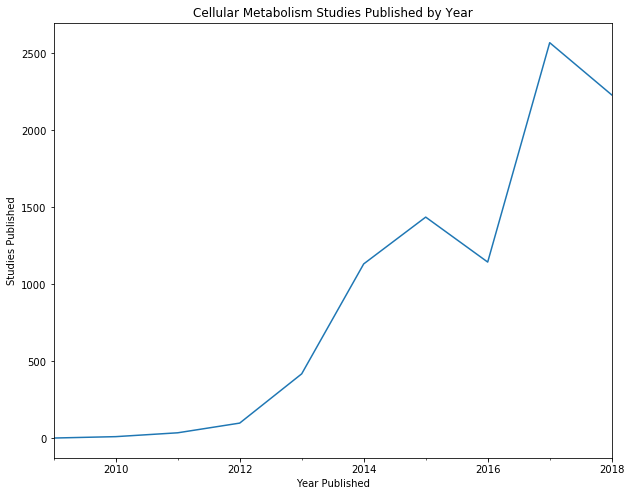

In [833]:
# convert the 'Publication date' column to datetime format 
data['Publication year'] = pd.to_datetime(data['Publication year'], format='%Y') 

# Check the format of 'Date' column 
data.info() 

df_sorted_by_date = data.sort_values(by=['Publication year'])

plot2 = df_sorted_by_date['Publication year'].value_counts().sort_index().plot(figsize=(10,8), title='Cellular Metabolism Studies Published by Year')

# Add x- and y- axes labels
plot2.set_xlabel("Year Published")
plot2.set_ylabel("Studies Published")

As shown in the line graph, there is a significant increase in cellular metabolism studies done since 2013, demonstrating a market need for more cellular metabolism insights.

### 3. Cell Type

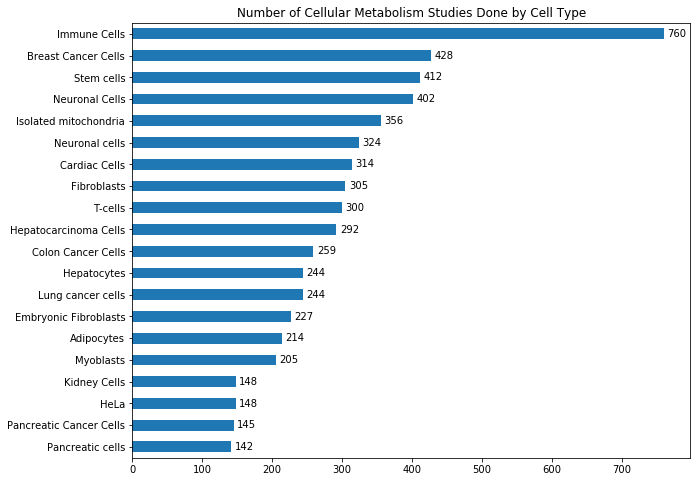

In [834]:
# Look at top 20 most researched cell lines
plot3 = data['Cell Type'].value_counts()[:20].plot(kind='barh', figsize=(10,8), title='Number of Cellular Metabolism Studies Done by Cell Type')
plot3.invert_yaxis()

# set individual bar labels using above list
for i in plot3.patches:
    # get_width pulls left or right; get_y pushes up or down
    plot3.text(i.get_width()+5.0, i.get_y()+.38, str(i.get_width()))

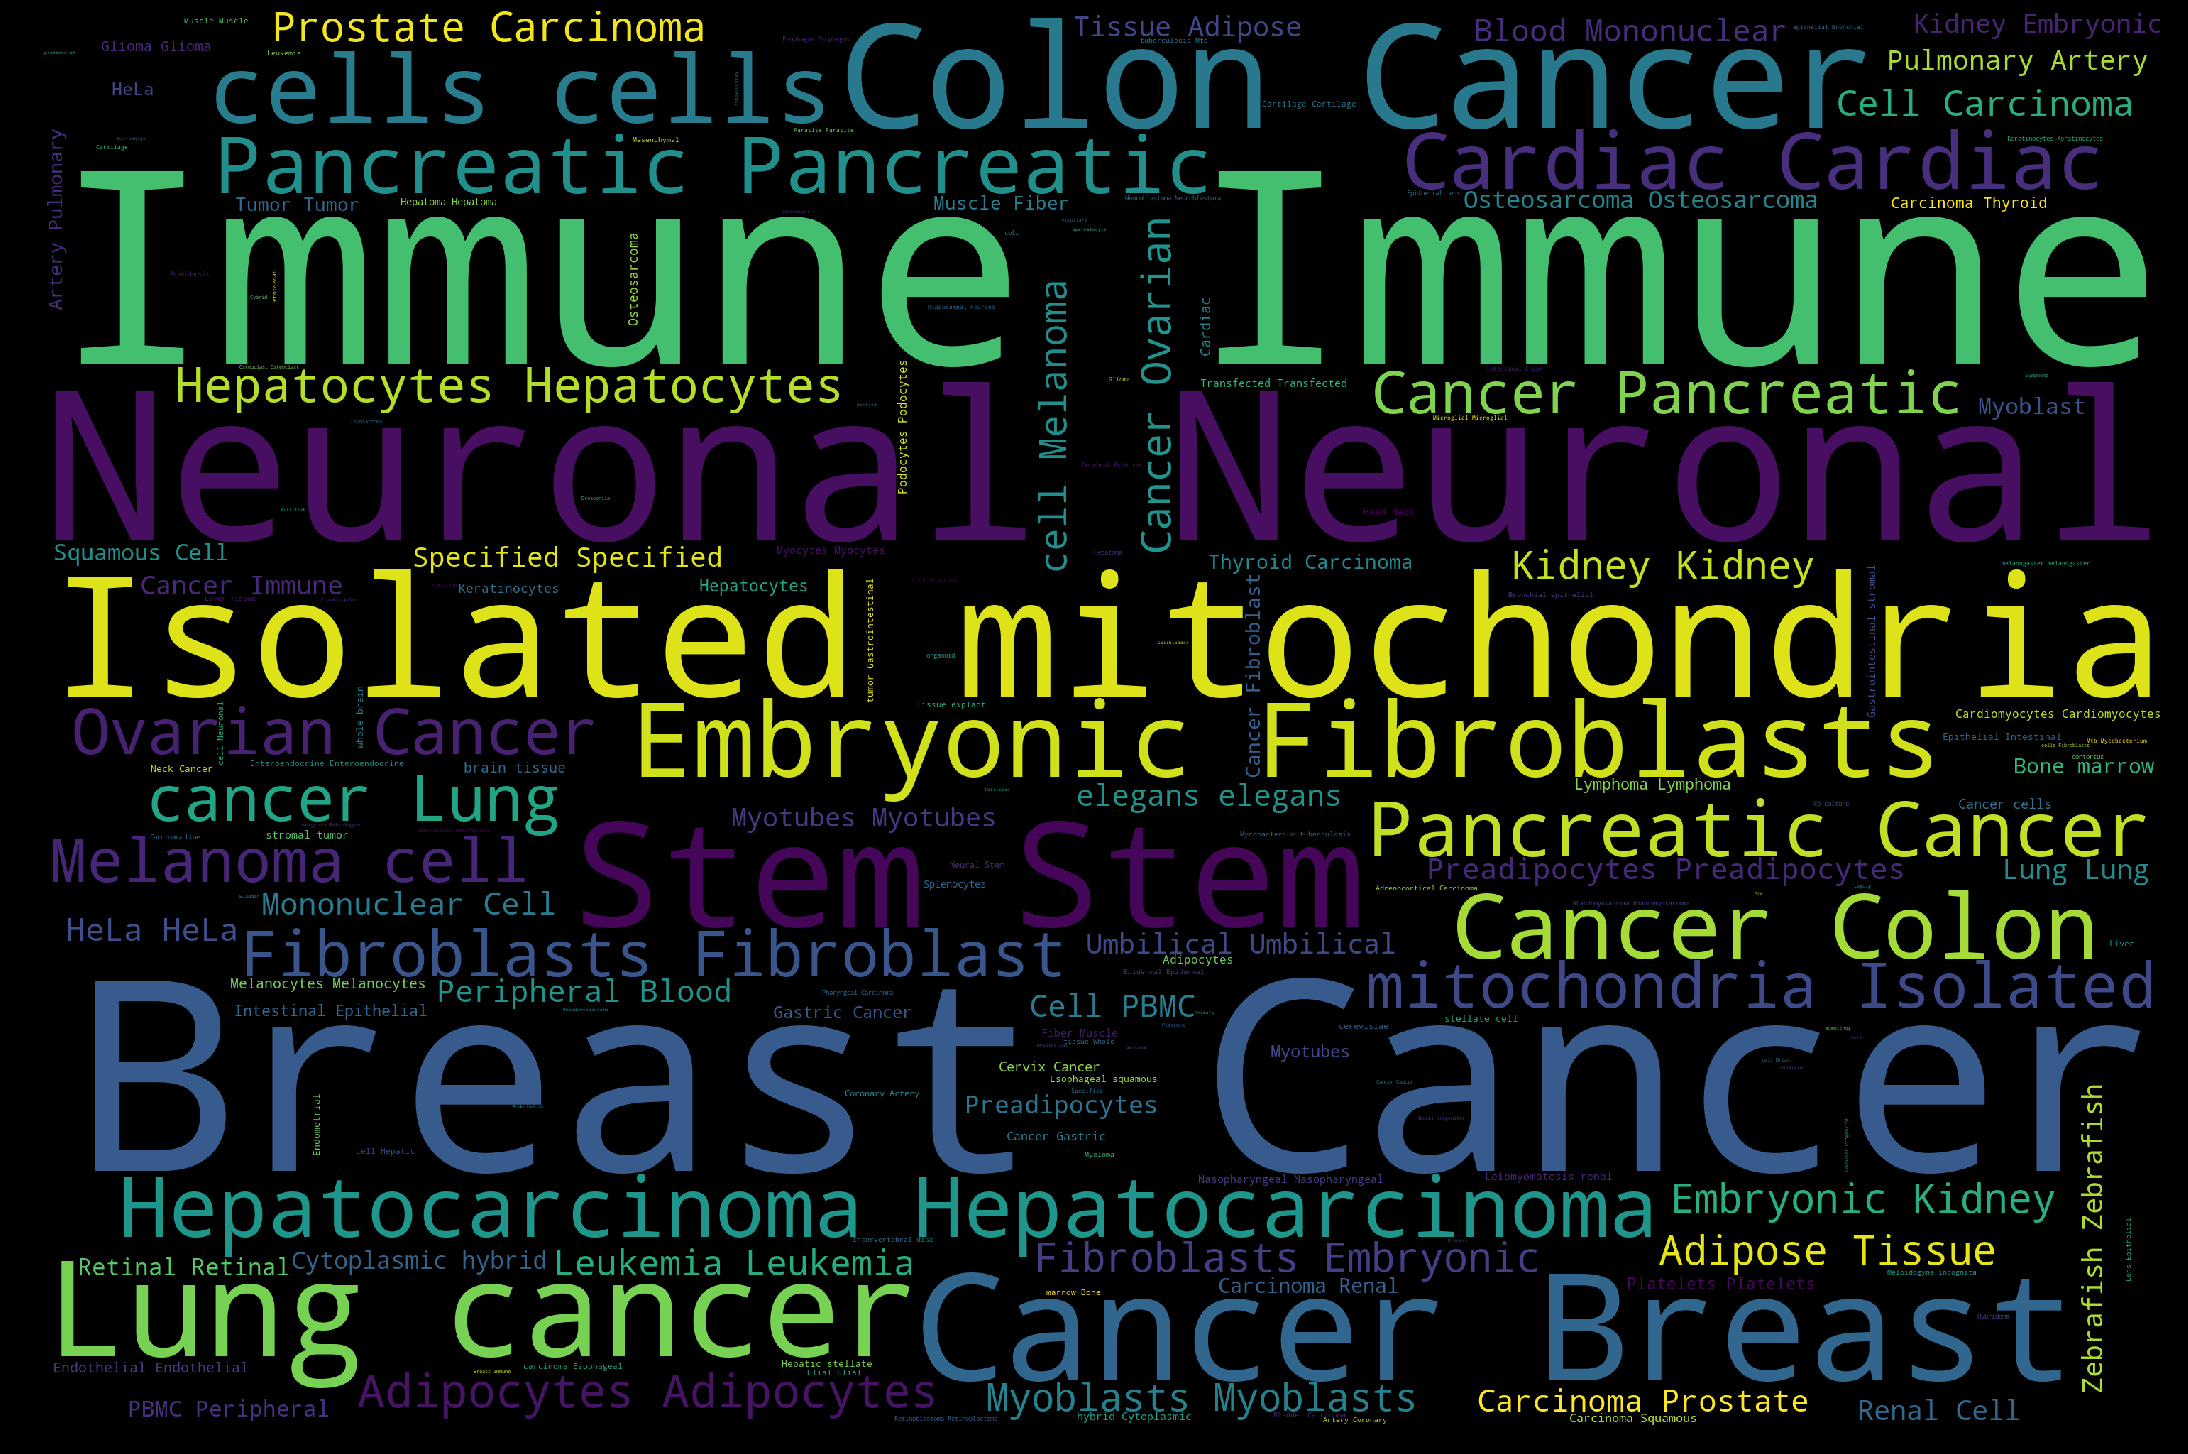

In [835]:
data['Cell Type'] = data['Cell Type'].astype(str)
data['Cell Type'] = data['Cell Type'].str.split(' ')

# Convert a column of lists to a column of strings
# Reference: https://stackoverflow.com/questions/45306988/column-of-lists-convert-list-to-string-as-a-new-column
data['Cell Type'] = data['Cell Type'].apply(lambda x: ' '.join(map(str, x)))

# Ignore ',cells' from wordcloud
data['Cell Type'] = data['Cell Type'].str.replace(' Cells' , '')
data['Cell Type'] = data['Cell Type'].str.replace(' cells' , '')
text = data['Cell Type'].str.cat(sep=' ')

# Generate word cloud for most researched cell types
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(text)
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'none')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

Future effort should include looking at how to generate a phrases cloud rather than a word cloud since phrases cloud would be more meaningful.

### 4. Metabolic assays (Work in Progress)

Here we look at which of our competitor's metabolic assays are the most popular

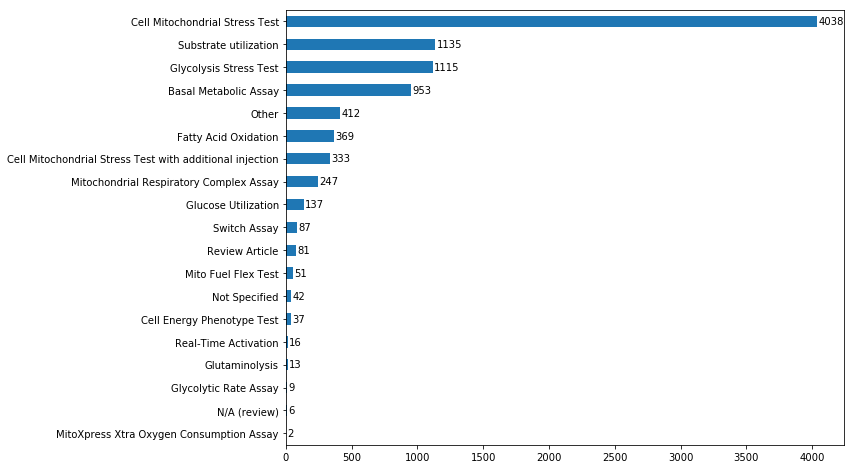

In [836]:
plot4 = data['XF Assay'].value_counts().plot(kind='barh', figsize=(10,8))
plot4.invert_yaxis()

# # create a list to collect the plt.patches data
# totals4 = []

# # find the values and append to list
# for i in plot1.patches:
#     totals4.append(i.get_width())

# # set individual bar lables using above list
# total4 = sum(totals4)

# set individual bar lables using above list
for i in plot4.patches:
    # get_width pulls left or right; get_y pushes up or down
    plot4.text(i.get_width()+10.0, i.get_y()+.38, str(i.get_width()))

**Cell Mitochondrial Stress Test**: measures basal respiration, ATP-linked respiration, H+ (Proton) leak, maximal respiration, spare respiratory capacity, and non-mitochondrial respiration using modulators of cellular respiration.

**Glycolysis Stress Test**: measures basal glycolysis and glycolysis capacity upon blockage of mitochondrial ATP production using respiratory modulators. Non-glycolytic acidification is assessed through glucose starvation.

**Substrate Utilization**

**Basal Metabolic Assay**

**Fatty Acid Oxidation**

**Mitochondrial Respiratory Complex Assay**

**Glucose Utilization**

**Switch Assay**

**Mito Fuel Flex Test**

**Cell Energy Phenotype Test**

**Real-Time Activation**

**Glutaminolysis**

**Glycolytic Rate Assay**

**MitoXpress Xtra Oxygen Consumption Assay**